# Evaluation

## Introduction

This notebook demonstrates how to evaluate the performance of a fine-tuned multimodal AI model on the [SIIM-ISIC Melanoma Classification](https://challenge2020.isic-archive.com/) dataset. We'll compare the base Gemma 3 model with our fine-tuned version to assess improvements in melanoma detection capabilities.

The SIIM-ISIC dataset contains over 33,000 dermoscopic images of skin lesions with corresponding labels indicating whether each lesion is benign or malignant melanoma. The dataset was released as part of the ISIC 2020 Challenge to help improve melanoma detection algorithms.

Our goal is to evaluate how well the fine-tuned model performs compared to the base model on this specialized medical imaging task. We'll run inference on test images and analyze the results to determine accuracy, precision, recall, and other key metrics.

## Install dependencies

Let's start by installing the required packages:

In [1]:
# Install required packages
!pip install transformers==4.51.3 -q
!pip install torch==2.7.0 -q
!pip install accelerate==1.6.0 -q
!pip install pillow==11.2.1 -q
!pip install matplotlib==3.9.4 -q
!pip install sentencepiece==0.2.0 -q
!pip install protobuf==3.20.3 -q
!pip install peft==0.15.2 -q
!pip install bitsandbytes==0.35.4 -q
!pip install bitsandbytes-cuda111==0.26.0.post2 -q
!pip install triton==3.3.0 -q

## Set up your environment

In [2]:
# If you're running this in Google Colab or Vertex AI Workbench, make sure you're 
# authenticated with Google Cloud:
# !gcloud auth login
# !gcloud config set project YOUR_PROJECT_ID

## Import libraries and set up configuration

In [3]:
import os
import json
import time
import re
import subprocess
import tempfile
import numpy as np
import pandas as pd
import time
import torch
import traceback
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from datetime import datetime
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoProcessor
from peft import PeftModel
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Configuration
GCS_BUCKET = "axolotl-multimodal-tuning-isic-2020-dataset" # Replace with your bucket

# Set up Hugging Face authentication
import huggingface_hub

# Note: Before running this notebook, make sure to:
# 1. Create a Hugging Face token at https://huggingface.co/settings/tokens if you don't have one
# 2. Replace "YOUR_HUGGING_FACE_TOKEN" below with your actual token
# 3. Make sure you have access to the Gemma 3 model (may require accepting model terms of use)
huggingface_hub.login(token="YOUR_HUGGING_FACE_TOKEN")

# If you're running this in Google Colab or Vertex AI Workbench, make sure you're 
# authenticated with Google Cloud:
# !gcloud auth login
# !gcloud config set project YOUR_PROJECT_ID

# Configure CUDA environment
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
os.environ["PYTORCH_USE_CUDA_DSA"] = "1"

# Set device based on availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

Using device: cuda
CUDA version: 12.6


## Data Preparation

First, let's download the necessary model files and test images. We'll create temporary directories to store these files and then download them from Google Cloud Storage.

In [ ]:
# Create temporary directories
temp_dir = tempfile.mkdtemp()
tuned_model_dir = os.path.join(temp_dir, "tuned_model")
image_dir = os.path.join(temp_dir, "images")
os.makedirs(tuned_model_dir, exist_ok=True)
os.makedirs(image_dir, exist_ok=True)

print(f"Created temporary directories:\nTuned Model: {tuned_model_dir}\nImages: {image_dir}")

# Download the fine-tuned model files
print("\nDownloading fine-tuned model files...")
subprocess.run(["gsutil", "-m", "cp", "-r", f"gs://{GCS_BUCKET}/tuned-models/*", tuned_model_dir])

# Download test images
print("\nDownloading test images...")
subprocess.run(["gsutil", "-m", "cp", f"gs://{GCS_BUCKET}/processed_images/test/*.jpg", image_dir], check=False)

# Download ground truth labels for test images (if available)
print("\nDownloading test labels...")
subprocess.run(["gsutil", "-m", "cp", f"gs://{GCS_BUCKET}/test_labels.csv", temp_dir], check=False)

# List downloaded files
print("\nDownloaded model files:")
model_files = os.listdir(tuned_model_dir)
for file in model_files:
    print(f"  - {file}")

print("\nDownloaded test images:")
image_files = os.listdir(image_dir)
print(f"  - Total images: {len(image_files)}")
if len(image_files) > 0:
    print(f"  - Sample images: {', '.join(image_files[:5])}")

## Load Ground Truth Labels

Let's load the ground truth labels for our test images from the ISIC dataset.

In [5]:
def load_ground_truth_data():
    """
    Load ground truth data from the ISIC dataset
    """
    print("\nLoading ground truth data...")
    
    try:
        # Try multiple possible locations for the ground truth file
        possible_paths = [
            os.path.join(temp_dir, "test_labels.csv"),  # Custom test labels if provided
            os.path.join(temp_dir, "ISIC_2020_Training_GroundTruth_v2.csv"),  # If downloaded to temp
            "ISIC_2020_Training_GroundTruth_v2.csv"  # In current directory
        ]
        
        # Try to download from GCS if not found locally
        gcs_path = f"gs://{GCS_BUCKET}/isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth_v2.csv"
        
        # Check all possible local paths first
        for path in possible_paths:
            if os.path.exists(path):
                print(f"Loading ground truth from: {path}")
                gt_data = pd.read_csv(path)
                break
        else:
            # If not found locally, try to download from GCS
            print(f"Ground truth not found locally, attempting to download from: {gcs_path}")
            download_path = os.path.join(temp_dir, "ISIC_2020_Training_GroundTruth_v2.csv")
            subprocess.run(["gsutil", "cp", gcs_path, download_path], check=False)
            
            if os.path.exists(download_path):
                print(f"Successfully downloaded ground truth data")
                gt_data = pd.read_csv(download_path)
            else:
                print("Failed to download ground truth data. Will proceed without labels.")
                return {}
        
        print(f"Loaded {len(gt_data)} ground truth labels")
        
        # Show a sample of the data
        print("\nGround truth data sample:")
        print(gt_data.head())
        
        # Extract image names and labels
        image_to_label = dict(zip(
            gt_data['image_name'].apply(lambda x: f"{x}.jpg"), 
            gt_data['target']
        ))
        
        # Count melanoma vs non-melanoma
        melanoma_count = gt_data['target'].sum()
        print(f"Dataset contains: {melanoma_count} melanoma images, {len(gt_data) - melanoma_count} non-melanoma images")
        
        return image_to_label
    except Exception as e:
        print(f"Error loading ground truth labels: {e}")
        return {}

# Load ground truth labels
image_to_label = load_ground_truth_data()


Loading ground truth data...
Ground truth not found locally, attempting to download from: gs://axolotl-multimodal-tuning-isic-2020-dataset/isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth_v2.csv


Copying gs://axolotl-multimodal-tuning-isic-2020-dataset/isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth_v2.csv...
/ [1 files][  2.3 MiB/  2.3 MiB]                                                
Operation completed over 1 objects/2.3 MiB.                                      


Successfully downloaded ground truth data
Loaded 33126 ground truth labels

Ground truth data sample:
     image_name  patient_id   lesion_id     sex  age_approx  \
0  ISIC_2637011  IP_7279968  IL_7972535    male        45.0   
1  ISIC_0015719  IP_3075186  IL_4649854  female        45.0   
2  ISIC_0052212  IP_2842074  IL_9087444  female        50.0   
3  ISIC_0068279  IP_6890425  IL_4255399  female        45.0   
4  ISIC_0074268  IP_8723313  IL_6898037  female        55.0   

  anatom_site_general_challenge diagnosis benign_malignant  target  
0                     head/neck   unknown           benign       0  
1               upper extremity   unknown           benign       0  
2               lower extremity     nevus           benign       0  
3                     head/neck   unknown           benign       0  
4               upper extremity   unknown           benign       0  
Dataset contains: 584 melanoma images, 32542 non-melanoma images


## Model Loading and Inference Functions

Now let's define functions to load the models and run inference.

In [6]:
def load_models(base_model_id="google/gemma-3-4b-it", tuned_model_path=None):
    """
    Load base and fine-tuned models with their tokenizers and processors.
    Ensures the 'base_model' returned is pristine if a 'tuned_model' is also loaded.
    """
    print(f"Loading tokenizer and processor for {base_model_id}...")
    # Load tokenizer and processor
    tokenizer = AutoTokenizer.from_pretrained(base_model_id)
    processor = AutoProcessor.from_pretrained(base_model_id)
    
    # Determine device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_dtype = torch.bfloat16 if device == "cuda" else torch.float32
    
    # Load the pristine base model for base evaluation
    print(f"Loading pristine base model {base_model_id}...")
    pristine_base_model = AutoModelForCausalLM.from_pretrained(
        base_model_id,
        torch_dtype=model_dtype,
        device_map="auto"
    )
    pristine_base_model.eval() # Set to evaluation mode
    print("Pristine base model loaded successfully.")
    
    loaded_tuned_model = None
    if tuned_model_path and os.path.exists(tuned_model_path):
        print(f"Preparing to load fine-tuned model from {tuned_model_path}...")
        
        # Load a SEPARATE instance of the base model specifically for applying the adapter
        print(f"Loading a fresh base model instance ({base_model_id}) to apply adapter...")
        base_model_for_adapter = AutoModelForCausalLM.from_pretrained(
            base_model_id,
            torch_dtype=model_dtype,
            device_map="auto"
        )
        base_model_for_adapter.eval()
        print("Fresh base model instance for adapter loaded successfully.")
        
        try:
            print(f"Applying fine-tuned adapter from {tuned_model_path} to the fresh base model instance...")
            adapter_config_path = os.path.join(tuned_model_path, "adapter_config.json")
            adapter_model_path = os.path.join(tuned_model_path, "adapter_model.safetensors")
            
            print(f"Adapter config exists: {os.path.exists(adapter_config_path)}")
            print(f"Adapter model exists: {os.path.exists(adapter_model_path)}")
            
            if not os.path.exists(adapter_config_path) or not os.path.exists(adapter_model_path):
                print(f"Missing adapter files in {tuned_model_path}, cannot load fine-tuned model.")
            else:
                loaded_tuned_model = PeftModel.from_pretrained(
                    base_model_for_adapter,
                    tuned_model_path
                )
                loaded_tuned_model.eval() # Set PeftModel to evaluation mode
                print("Fine-tuned model (adapter on fresh base) loaded successfully.")
        except Exception as e:
            print(f"Error loading or applying fine-tuned model adapter: {e}")
            # loaded_tuned_model will remain None, pristine_base_model is still available
            # Clean up the base_model_for_adapter if it was loaded but adapter failed
            if 'base_model_for_adapter' in locals():
                del base_model_for_adapter
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
    
    return {
        "base_model": pristine_base_model,
        "tuned_model": loaded_tuned_model,
        "tokenizer": tokenizer,
        "processor": processor
    }

In [7]:
POSITIVE_PATTERNS = [
    r"Based on the image provided, this appears to be malignant melanoma",
    r"Based on this microscopic image, this appears to be malignant melanoma.",
    r"Based on this image, it appears to be malignant melanoma",
    r"Based on this image, this appears to be malignant melanoma",
    r"Based on the image, this appears to be malignant melanoma",
    # explicit "yes" pattern as well for direct matches
    r"yes, this appears to be malignant melanoma"
]

NEGATIVE_PATTERNS = [
    r"does not appear to be malignant melanoma",
    # explicit "no" pattern
    r"no, this does not appear to be malignant melanoma"
]

def run_inference(model, tokenizer, processor, image_path, prompt):
    """
    Run inference on a single image with a given model, using robust pattern matching for classification.
    
    Args:
        model: Model to use for inference
        tokenizer: Tokenizer for the model
        processor: Processor for the model
        image_path: Path to the image file
        prompt: Text prompt to send with the image
        
    Returns:
        Dictionary with response data and metrics
    """
    image_filename = os.path.basename(image_path)
    print(f"Running inference on {image_filename}...")
    
    try:
        # Load image
        image = Image.open(image_path)
        
        # Create messages in Gemma 3 format
        messages = [
            {"role": "system", "content": "You are a dermatology assistant that helps identify potential melanoma from skin lesion images."},
            {"role": "user", "content": [
                {"type": "image", "source": image},
                {"type": "text", "text": prompt}
            ]}
        ]
        
        # Apply the chat template
        formatted_prompt = tokenizer.apply_chat_template(
            messages, 
            tokenize=False, 
            add_generation_prompt=True
        )
        
        # Process inputs
        inputs = processor(
            text=formatted_prompt,
            images=image,
            return_tensors="pt"
        ).to(model.device)
        
        # Generate prediction
        start_time = time.time()
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=500,
                do_sample=False
            )
        
        # Decode output
        full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        elapsed = time.time() - start_time
        
        # Extract the model's response
        if "<start_of_turn>model" in full_response:
            model_response = full_response.split("<start_of_turn>model", 1)[1].strip()
        elif "model" in full_response:
            model_response = full_response.split("model", 1)[1].strip()
        else:
            model_response = full_response # Use the full response if no clear model turn marker
        
        # Determine classification using robust pattern matching
        is_melanoma = None
        response_text_lower = model_response.lower() # Convert to lowercase once for all checks

        # Check for positive patterns
        for pattern in POSITIVE_PATTERNS:
            if re.search(pattern, response_text_lower, re.IGNORECASE):
                is_melanoma = 1  # Positive prediction (melanoma)
                break # Found a positive match, no need to check further positive or negative patterns
        
        # If no positive match, check for negative patterns
        if is_melanoma is None: # Only check negative if not already classified as positive
            for pattern in NEGATIVE_PATTERNS:
                if re.search(pattern, response_text_lower, re.IGNORECASE):
                    is_melanoma = 0  # Negative prediction (not melanoma)
                    break # Found a negative match
        
        return {
            "success": True,
            "response": model_response, # Return the model's actual response part
            "is_melanoma": is_melanoma,
            "inference_time": elapsed
        }
        
    except Exception as e:
        print(f"Error during inference on {image_filename}: {str(e)}")
        traceback.print_exc()
        return {
            "success": False,
            "error": str(e),
            "is_melanoma": None,
            "inference_time": 0
        }

## Evaluate Models on Test Images

Now let's define a function to evaluate both models on our test dataset.

In [8]:
def evaluate_models_on_dataset(
    base_model_id="google/gemma-3-4b-it",
    tuned_model_path=None,
    test_image_dir=None,
    num_images=10,  # Limit number of images to evaluate
    results_dir="evaluation_results"
):
    """
    Evaluate base and fine-tuned models on a set of test images
    
    Args:
        base_model_id: Hugging Face model ID for the base model
        tuned_model_path: Path to the fine-tuned model
        test_image_dir: Directory containing test images
        num_images: Number of images to evaluate (0 for all)
        results_dir: Directory to save results
        
    Returns:
        Dictionary with evaluation results
    """
    # Create results directory
    os.makedirs(results_dir, exist_ok=True)
    
    if not test_image_dir or not os.path.exists(test_image_dir):
        raise ValueError(f"Test image directory not found: {test_image_dir}")
    
    # Load models
    models = load_models(base_model_id, tuned_model_path)
    base_model = models["base_model"]
    tuned_model = models["tuned_model"]
    tokenizer = models["tokenizer"]
    processor = models["processor"]
    
    if not base_model:
        raise ValueError("Base model could not be loaded")
    
    # Get list of test images
    image_files = [f for f in os.listdir(test_image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Sort images for consistent order across runs
    image_files.sort()
    
    # Limit number of images if specified
    if num_images > 0 and num_images < len(image_files):
        image_files = image_files[:num_images]
    
    print(f"Evaluating {len(image_files)} test images")
    
    # Standard prompt for all evaluations
    prompt = "This is a skin lesion image. Does this appear to be malignant melanoma? Please explain your reasoning and conclude with either 'Yes, this appears to be malignant melanoma.' or 'No, this does not appear to be malignant melanoma.'"
    
    # Initialize results
    results = {
        "base_model": [],
        "tuned_model": []
    }
    
    # Process each image
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(test_image_dir, image_file)
        
        # Get ground truth if available
        ground_truth = image_to_label.get(image_file, None)
        
        print(f"\nProcessing image {i+1}/{len(image_files)}: {image_file}")
        
        # Display the image
        img = Image.open(image_path)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Test Image: {image_file}' + 
                 (f' (Ground Truth: {"Melanoma" if ground_truth == 1 else "Non-melanoma"})' if ground_truth is not None else ''))
        plt.show()
        
        # Base model inference
        print("Running base model inference...")
        base_result = run_inference(base_model, tokenizer, processor, image_path, prompt)
        base_result["image"] = image_file
        base_result["ground_truth"] = ground_truth
        results["base_model"].append(base_result)
        
        # Print base model result
        print("\nBASE MODEL RESPONSE:")
        print("-" * 80)
        if base_result["success"]:
            print(base_result["response"])
            print(f"Classification: {'Melanoma' if base_result['is_melanoma'] == 1 else 'Non-melanoma' if base_result['is_melanoma'] == 0 else 'Uncertain'}")
            print(f"Inference time: {base_result['inference_time']:.2f} seconds")
        else:
            print(f"Error: {base_result.get('error', 'Unknown error')}")
        
        # Fine-tuned model inference (if available)
        if tuned_model:
            print("\nRunning fine-tuned model inference...")
            tuned_result = run_inference(tuned_model, tokenizer, processor, image_path, prompt)
            tuned_result["image"] = image_file
            tuned_result["ground_truth"] = ground_truth
            results["tuned_model"].append(tuned_result)
            
            # Print fine-tuned model result
            print("\nFINE-TUNED MODEL RESPONSE:")
            print("-" * 80)
            if tuned_result["success"]:
                print(tuned_result["response"])
                print(f"Classification: {'Melanoma' if tuned_result['is_melanoma'] == 1 else 'Non-melanoma' if tuned_result['is_melanoma'] == 0 else 'Uncertain'}")
                print(f"Inference time: {tuned_result['inference_time']:.2f} seconds")
            else:
                print(f"Error: {tuned_result.get('error', 'Unknown error')}")
        
        print("=" * 80)
    
    # Save results to a JSON file
    os.makedirs(results_dir, exist_ok=True)
    base_results_file = os.path.join(results_dir, "base_model_results.json")
    tuned_results_file = os.path.join(results_dir, "tuned_model_results.json")
    
    with open(base_results_file, 'w') as f:
        json.dump(results["base_model"], f, indent=2)
    
    with open(tuned_results_file, 'w') as f:
        json.dump(results["tuned_model"], f, indent=2)
    
    print(f"\nEvaluation results saved to:")
    print(f"  Base model: {base_results_file}")
    print(f"  Tuned model: {tuned_results_file}")
    
    return results

## Run the Evaluation

Now let's run the evaluation on our test images.

Loading tokenizer and processor for google/gemma-3-4b-it...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading pristine base model google/gemma-3-4b-it...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Pristine base model loaded successfully.
Preparing to load fine-tuned model from /var/tmp/tmpw3qktb8j/tuned_model...
Loading a fresh base model instance (google/gemma-3-4b-it) to apply adapter...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fresh base model instance for adapter loaded successfully.
Applying fine-tuned adapter from /var/tmp/tmpw3qktb8j/tuned_model to the fresh base model instance...
Adapter config exists: True
Adapter model exists: True
==============================WARNING: DEPRECATED!==============================
WARNING! This version of bitsandbytes is deprecated. Please switch to `pip install bitsandbytes` and the new repo: https://github.com/TimDettmers/bitsandbytes
==============================WARNING: DEPRECATED!==============================
Fine-tuned model (adapter on fresh base) loaded successfully.
Evaluating 10 test images

Processing image 1/10: ISIC_0076262.jpg


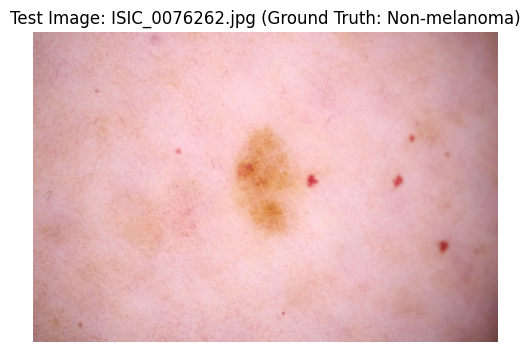

Running base model inference...
Running inference on ISIC_0076262.jpg...


/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `64` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



BASE MODEL RESPONSE:
--------------------------------------------------------------------------------
Okay, let's analyze this skin lesion image.

**Observations:**

*   **Color:** The lesion exhibits a significant variation in color, with areas of brown, reddish-brown, and some areas appearing darker. This uneven pigmentation is a concerning feature.
*   **Shape:** The lesion has irregular borders – it’s not clearly defined or smooth. It appears somewhat jagged and uneven.
*   **Size:** While the exact size is difficult to determine from the image, it appears to be larger than a typical melanocytic nevus (mole).
*   **Satellite Lesions:** There are several smaller, reddish-pink spots (satellite lesions) surrounding the main lesion. These are often associated with melanoma.
*   **Inflammation:** There is some visible inflammation or redness around the edges of the lesion.

**Reasoning:**

The combination of uneven pigmentation, irregular borders, the presence of satellite lesions, and

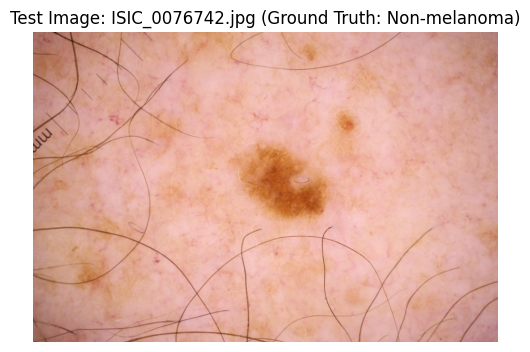

Running base model inference...
Running inference on ISIC_0076742.jpg...

BASE MODEL RESPONSE:
--------------------------------------------------------------------------------
Okay, let's analyze this skin lesion image.

**Here's my assessment:**

This lesion exhibits several concerning features that raise suspicion for melanoma. Here's a breakdown of my reasoning:

*   **Color Variation:** The lesion displays a significant amount of color variation – shades of brown, darker brown, and some lighter areas. This uneven pigmentation is a classic sign of melanoma.
*   **Irregular Borders:** The edges of the lesion are not well-defined or smooth. They appear irregular and notched, which is a key indicator of melanoma.
*   **Asymmetry:** While it's difficult to definitively assess symmetry in a still image, the lesion appears somewhat asymmetrical. Melanomas often have one half that doesn't match the other.
*   **Diameter:** The lesion appears to be approximately 6mm in diameter, which is ab

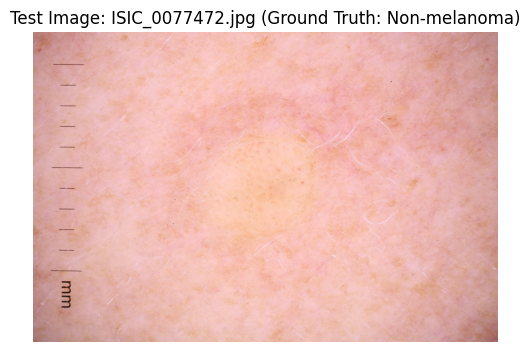

Running base model inference...
Running inference on ISIC_0077472.jpg...

BASE MODEL RESPONSE:
--------------------------------------------------------------------------------
Okay, let's analyze this skin lesion image.

**Observations:**

*   **Color:** The lesion exhibits a somewhat uneven color distribution, with a lighter central area transitioning to a slightly more pigmented, reddish-orange hue around the edges. This asymmetry is a key concerning feature.
*   **Shape:** The lesion has an irregular, somewhat circular shape, but it's not perfectly defined. There are some irregular borders and a slightly "rolled" appearance.
*   **Border:** The border is not smooth and well-defined. It appears ragged and uneven, which is a significant red flag.
*   **Size:** The lesion appears to be approximately 6mm in diameter, which is within the recommended ABCDE criteria for melanoma (though smaller lesions can still be melanoma).
*   **Location:** The location on the skin is not particularly r

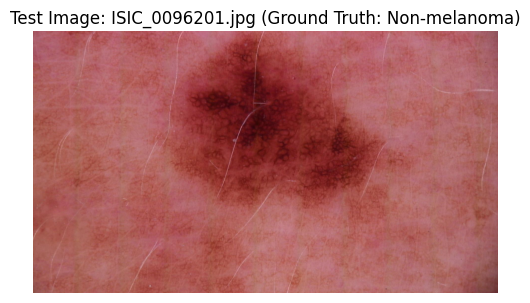

Running base model inference...
Running inference on ISIC_0096201.jpg...

BASE MODEL RESPONSE:
--------------------------------------------------------------------------------
Okay, let's analyze this skin lesion image.

**Observations:**

*   **Color:** The lesion exhibits a significant amount of dark brown and black pigmentation, with some areas appearing almost purple or reddish. This uneven coloration is a concerning feature.
*   **Shape:** The lesion has an irregular, poorly defined border. It doesn't have a neat, smooth outline, which is a red flag.
*   **Diameter:** The lesion appears to be relatively large, measuring approximately 6-8mm in diameter. While this isn't a definitive rule, larger lesions are more concerning.
*   **Surface Features:** There are multiple small, raised bumps (papules) and some darker, irregular areas within the lesion. This suggests a heterogeneous appearance, which can be seen in melanoma.
*   **Telangiectasia (Spider Veins):** The presence of small, 

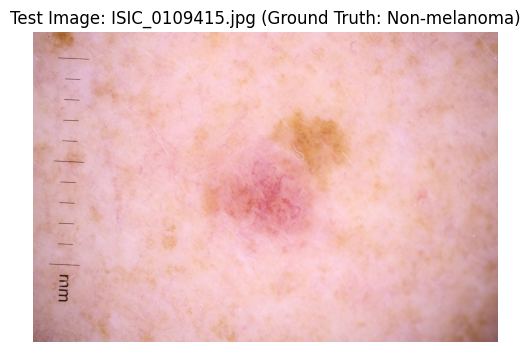

Running base model inference...
Running inference on ISIC_0109415.jpg...

BASE MODEL RESPONSE:
--------------------------------------------------------------------------------
Okay, let's analyze this skin lesion image.

**Observations:**

*   **Color Variation:** The lesion exhibits a significant range of colors, including shades of brown, reddish-brown, and some areas of lighter pigmentation. This uneven coloration is a concerning feature.
*   **Irregular Borders:** The edges of the lesion are not well-defined and appear ragged or blurred. This is a key indicator of melanoma.
*   **Asymmetry:** The lesion is asymmetrical – one half doesn't mirror the other. Melanoma often displays asymmetry.
*   **Diameter:** The lesion appears to be larger than 6mm (the recommended ABCDE rule threshold for concerning moles).
*   **Raised Appearance:** There is a noticeable raised area within the lesion, particularly in the center.

**Reasoning:**

The combination of uneven coloration, irregular bord

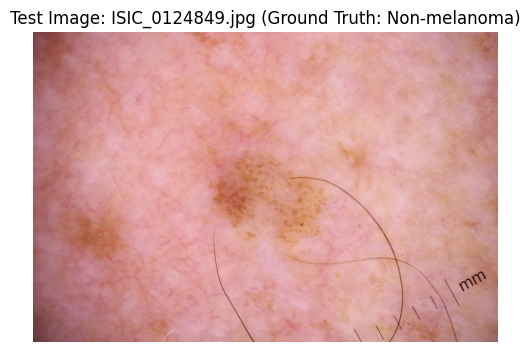

Running base model inference...
Running inference on ISIC_0124849.jpg...

BASE MODEL RESPONSE:
--------------------------------------------------------------------------------
Okay, let's analyze this skin lesion image.

**Observations:**

*   **Color:** The lesion exhibits a mottled appearance with areas of brown and darker pigmentation. This is not a uniform, even color, which is a concerning feature.
*   **Shape:** The lesion has irregular borders – it’s not clearly defined or circular. It appears to be somewhat jagged and uneven.
*   **Size:** Based on the scale bar, the lesion appears to be approximately 6mm in diameter. While 6mm is within the average size range for melanomas, the other features are more concerning.
*   **Texture:** The lesion has a slightly raised, rough texture.
*   **Surrounding Skin:** There is some redness (erythema) visible around the lesion, suggesting inflammation or irritation.

**Reasoning:**

The combination of irregular shape, uneven coloration, and a

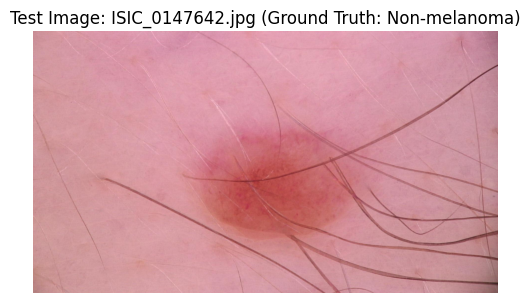

Running base model inference...
Running inference on ISIC_0147642.jpg...

BASE MODEL RESPONSE:
--------------------------------------------------------------------------------
Okay, let's analyze this image for potential melanoma.

**Observations:**

*   **Color:** The lesion exhibits a significant amount of variation in color, with areas of reddish-brown and darker hues. This uneven coloration is a concerning feature.
*   **Shape:** The lesion has irregular, poorly defined borders. It doesn't appear to be a smooth, round, or oval shape, which is typical of benign nevi.
*   **Size:** It appears to be relatively large, though the scale is difficult to determine precisely from the image. Larger lesions are more concerning.
*   **Elevation:** The lesion is raised above the surrounding skin.
*   **Hair:** The presence of hair growing *within* the lesion is also a concerning sign. Melanoma can sometimes invade hair follicles.

**Reasoning:**

The combination of uneven coloration, irregular 

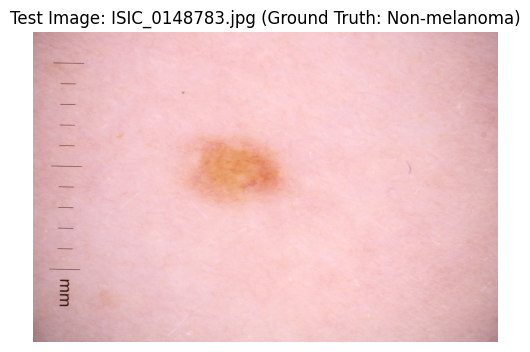

Running base model inference...
Running inference on ISIC_0148783.jpg...

BASE MODEL RESPONSE:
--------------------------------------------------------------------------------
Okay, let's analyze this skin lesion image.

**Observations:**

*   **Color:** The lesion exhibits a mottled color pattern with shades of brown, tan, and some darker areas. This uneven coloration is a concerning feature.
*   **Shape:** The lesion has irregular, poorly defined borders. It doesn't appear to be a smooth, round, or oval shape, which is typical of benign nevi.
*   **Size:** The lesion is approximately 6mm in diameter (as indicated by the ruler). While this size is relatively small, the irregular shape and color distribution raise suspicion.
*   **Location:** The lesion is located on the skin, which is a common site for melanomas.

**Reasoning:**

The combination of irregular borders, uneven coloration, and a relatively small size is concerning. These features are suggestive of melanoma. While a small 

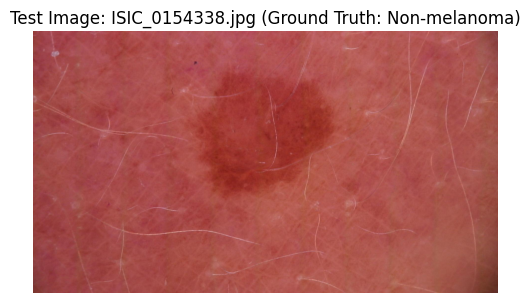

Running base model inference...
Running inference on ISIC_0154338.jpg...

BASE MODEL RESPONSE:
--------------------------------------------------------------------------------
Okay, let's analyze this skin lesion image.

**Observations:**

*   **Color:** The lesion exhibits a dark, irregular brown color with some darker blue-black hues. This is a concerning feature, as melanomas often have uneven pigmentation.
*   **Shape:** The lesion has an irregular, poorly defined border. Melanomas frequently lack the neat, well-circumscribed borders seen in benign nevi (moles).
*   **Diameter:** The lesion appears to be relatively large, measuring approximately 6-8mm in diameter. While size isn't the *only* factor, larger lesions are more likely to be melanoma.
*   **Surface Features:** There are some subtle, irregular surface features visible, which could indicate ulceration or scaling, though it's difficult to fully assess this in the image.

**Reasoning:**

Based on these observations, the lesi

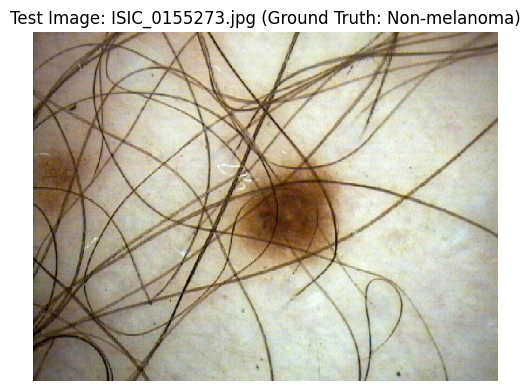

Running base model inference...
Running inference on ISIC_0155273.jpg...

BASE MODEL RESPONSE:
--------------------------------------------------------------------------------
Okay, let's analyze this image for potential melanoma.

**Observations:**

*   **Color:** The lesion is a dark brown color, which is concerning. Melanomas often present with dark brown or black pigmentation.
*   **Shape:** The lesion has an irregular, uneven border. Melanomas frequently exhibit poorly defined, ragged, or notched borders, rather than smooth, regular edges.
*   **Size:** It appears to be relatively large, though the scale is difficult to determine precisely. Melanomas can grow to a significant size.
*   **Asymmetry:** The lesion appears asymmetrical. Melanomas are often described as "not symmetrical," meaning one half doesn't match the other.
*   **Hair:** The presence of hair around the lesion can make it difficult to assess the lesion's true borders and depth.

**Reasoning:**

Based on these obse

In [9]:
# Run the evaluation with a limited number of images for demonstration
# Set num_images=0 to evaluate all images
evaluation_results = evaluate_models_on_dataset(
    base_model_id="google/gemma-3-4b-it",
    tuned_model_path=tuned_model_dir,
    test_image_dir=image_dir,
    num_images=10 # Limit to 10 images for this demonstration
)

In [10]:
evaluation_results

{'base_model': [{'success': True,
   'response': "Okay, let's analyze this skin lesion image.\n\n**Observations:**\n\n*   **Color:** The lesion exhibits a significant variation in color, with areas of brown, reddish-brown, and some areas appearing darker. This uneven pigmentation is a concerning feature.\n*   **Shape:** The lesion has irregular borders – it’s not clearly defined or smooth. It appears somewhat jagged and uneven.\n*   **Size:** While the exact size is difficult to determine from the image, it appears to be larger than a typical melanocytic nevus (mole).\n*   **Satellite Lesions:** There are several smaller, reddish-pink spots (satellite lesions) surrounding the main lesion. These are often associated with melanoma.\n*   **Inflammation:** There is some visible inflammation or redness around the edges of the lesion.\n\n**Reasoning:**\n\nThe combination of uneven pigmentation, irregular borders, the presence of satellite lesions, and some inflammation raises significant con

## Post-Processing and Analysis

After running inference on the test images, we'll need to post-process the results for accurate analysis.

In [17]:
def process_results(results_file):
    """
    Process results file to fix any null classifications and deduplicate entries
    """
    print(f"\nProcessing results from {results_file}")
    
    # Load the results
    with open(results_file, 'r') as f:
        results = json.load(f)
    
    print(f"Loaded {len(results)} results")
    
    # Fix null classifications
    fixed_count = 0
    for item in results:
        if 'is_melanoma' not in item or item['is_melanoma'] is None:
            # Try to infer from response text
            response = item.get('response', '').lower()
            if "yes, this appears to be malignant melanoma" in response:
                item['is_melanoma'] = 1
                fixed_count += 1
            elif "no, this does not appear to be malignant melanoma" in response:
                item['is_melanoma'] = 0
                fixed_count += 1
    
    print(f"Fixed {fixed_count} null classifications")
    
    # Count total melanoma/non-melanoma predictions
    melanoma_count = sum(1 for item in results if item.get('is_melanoma') == 1)
    non_melanoma_count = sum(1 for item in results if item.get('is_melanoma') == 0)
    null_count = sum(1 for item in results if item.get('is_melanoma') is None)
    
    print(f"Predictions: {melanoma_count} melanoma, {non_melanoma_count} non-melanoma, {null_count} uncertain")
    
    # Save processed results
    processed_file = results_file.replace('.json', '_processed.json')
    with open(processed_file, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"Processed results saved to {processed_file}")
    
    return results

# Process the results files
base_processed = process_results(os.path.join("evaluation_results", "base_model_results.json"))
tuned_processed = process_results(os.path.join("evaluation_results", "tuned_model_results.json"))


Processing results from evaluation_results/base_model_results.json
Loaded 10 results
Fixed 0 null classifications
Predictions: 10 melanoma, 0 non-melanoma, 0 uncertain
Processed results saved to evaluation_results/base_model_results_processed.json

Processing results from evaluation_results/tuned_model_results.json
Loaded 10 results
Fixed 0 null classifications
Predictions: 6 melanoma, 4 non-melanoma, 0 uncertain
Processed results saved to evaluation_results/tuned_model_results_processed.json


## Calculate Performance Metrics

Now let's calculate the performance metrics for both models.

In [18]:
def calculate_metrics(results):
    """
    Calculate performance metrics for a set of results
    
    Args:
        results: List of result items with ground_truth and is_melanoma fields
        
    Returns:
        Dictionary of metrics
    """
    # Extract only items with both ground truth and predictions
    valid_items = [
        item for item in results 
        if 'ground_truth' in item and item['ground_truth'] is not None 
        and 'is_melanoma' in item and item['is_melanoma'] is not None
    ]
    
    if not valid_items:
        print("No valid items with ground truth for calculating metrics")
        return {}
    
    # Extract ground truth and predictions
    y_true = [item['ground_truth'] for item in valid_items]
    y_pred = [item['is_melanoma'] for item in valid_items]
    
    # Calculate confusion matrix and derived metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate standard metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Calculate specificity (true negative rate)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Calculate balanced accuracy (average of recall and specificity)
    balanced_accuracy = (recall + specificity) / 2
    
    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "f1": f1,
        "balanced_accuracy": balanced_accuracy,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
        "valid_count": len(valid_items)
    }
    
    return metrics

# Calculate metrics for both models
base_metrics = calculate_metrics(base_processed)
tuned_metrics = calculate_metrics(tuned_processed)

# Print metrics summary
print("\nPerformance Metrics:")
print("=" * 50)

metrics_to_display = [
    ("Accuracy", "accuracy"),
    ("Precision", "precision"),
    ("Recall/Sensitivity", "recall"),
    ("Specificity", "specificity"),
    ("F1 Score", "f1"),
    ("Balanced Accuracy", "balanced_accuracy")
]

print("\nBase Model Metrics:")
for name, key in metrics_to_display:
    if key in base_metrics:
        print(f"  {name}: {base_metrics[key]:.4f}")

print("\nFine-tuned Model Metrics:")
for name, key in metrics_to_display:
    if key in tuned_metrics:
        print(f"  {name}: {tuned_metrics[key]:.4f}")

print("\nConfusion Matrix - Base Model:")
print(f"  True Negatives: {base_metrics.get('tn', 'N/A')}")
print(f"  False Positives: {base_metrics.get('fp', 'N/A')}")
print(f"  False Negatives: {base_metrics.get('fn', 'N/A')}")
print(f"  True Positives: {base_metrics.get('tp', 'N/A')}")

print("\nConfusion Matrix - Tuned Model:")
print(f"  True Negatives: {tuned_metrics.get('tn', 'N/A')}")
print(f"  False Positives: {tuned_metrics.get('fp', 'N/A')}")
print(f"  False Negatives: {tuned_metrics.get('fn', 'N/A')}")
print(f"  True Positives: {tuned_metrics.get('tp', 'N/A')}")


Performance Metrics:

Base Model Metrics:
  Accuracy: 0.0000
  Precision: 0.0000
  Recall/Sensitivity: 0.0000
  Specificity: 0.0000
  F1 Score: 0.0000
  Balanced Accuracy: 0.0000

Fine-tuned Model Metrics:
  Accuracy: 0.4000
  Precision: 0.0000
  Recall/Sensitivity: 0.0000
  Specificity: 0.4000
  F1 Score: 0.0000
  Balanced Accuracy: 0.2000

Confusion Matrix - Base Model:
  True Negatives: 0
  False Positives: 10
  False Negatives: 0
  True Positives: 0

Confusion Matrix - Tuned Model:
  True Negatives: 4
  False Positives: 6
  False Negatives: 0
  True Positives: 0


## Visualize Results

Now let's visualize the performance metrics and compare the models.

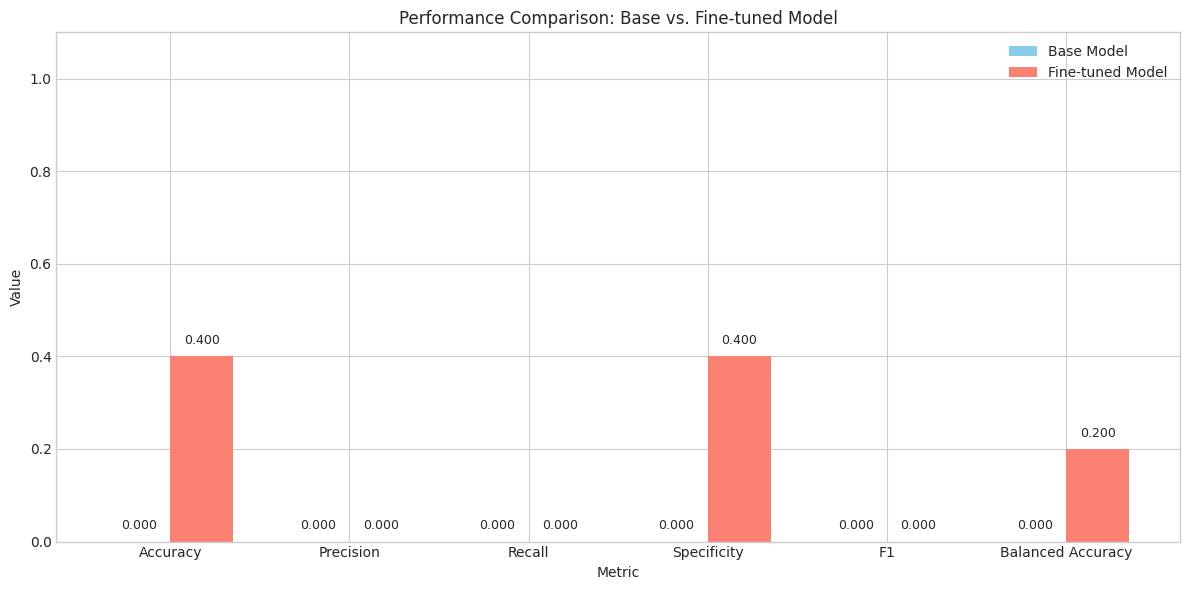

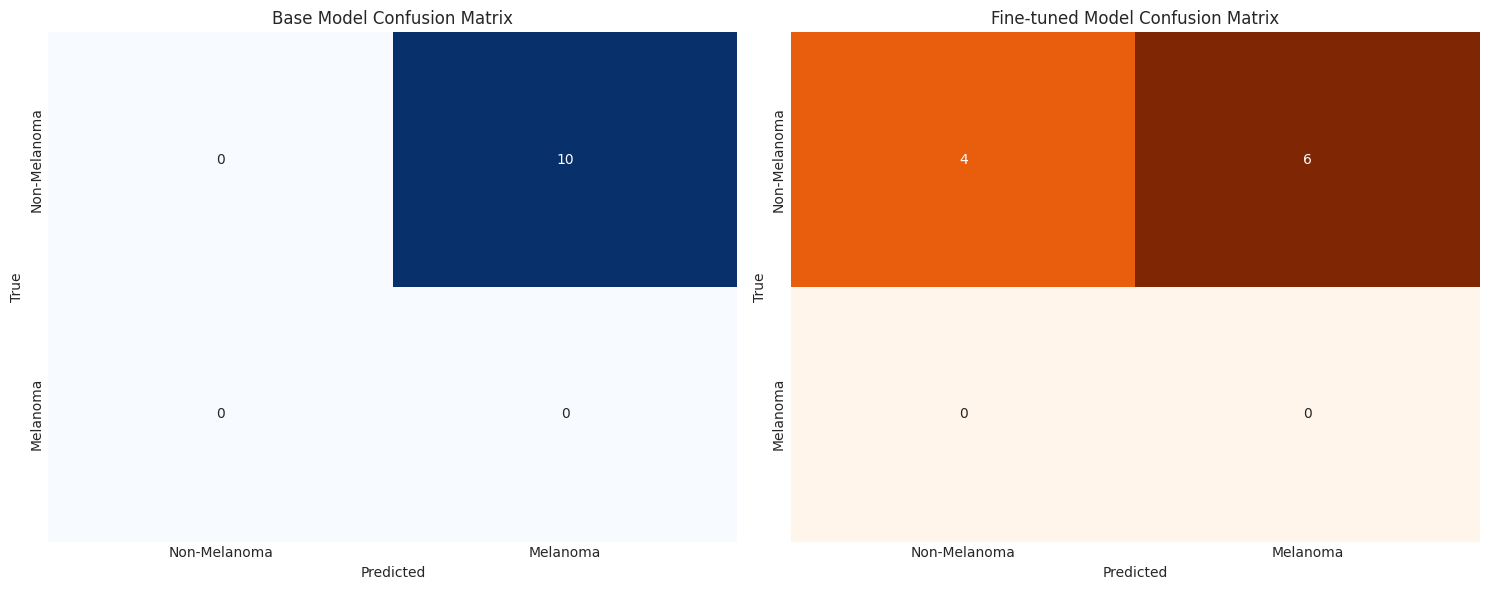

In [19]:
def visualize_performance_comparison(base_metrics, tuned_metrics):
    """
    Create visualizations comparing base and fine-tuned model performance
    """
    if not base_metrics or not tuned_metrics:
        print("Cannot create visualizations: missing metrics")
        return
    
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # 1. Performance Metrics Comparison
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'specificity', 'f1', 'balanced_accuracy']
    base_values = [base_metrics.get(m, 0) for m in metrics_to_plot]
    tuned_values = [tuned_metrics.get(m, 0) for m in metrics_to_plot]
    
    plt.figure(figsize=(12, 6))
    x = np.arange(len(metrics_to_plot))
    width = 0.35
    
    plt.bar(x - width/2, base_values, width, label='Base Model', color='skyblue')
    plt.bar(x + width/2, tuned_values, width, label='Fine-tuned Model', color='salmon')
    
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title('Performance Comparison: Base vs. Fine-tuned Model')
    plt.xticks(x, [m.replace('_', ' ').title() for m in metrics_to_plot])
    plt.ylim(0, 1.1)
    
    # Add value labels on bars
    for i, v in enumerate(base_values):
        plt.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    for i, v in enumerate(tuned_values):
        plt.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Calculate and display improvement percentages
    for i, (metric, base_val, tuned_val) in enumerate(zip(metrics_to_plot, base_values, tuned_values)):
        if base_val > 0:  # Avoid division by zero
            improvement = ((tuned_val - base_val) / base_val) * 100
            color = 'green' if improvement > 0 else 'red'
            plt.text(i, 1.05, f'{improvement:+.1f}%', ha='center', va='bottom', fontsize=10, color=color)
    
    plt.legend()
    plt.tight_layout()
    plt.savefig('evaluation_results/performance_comparison.png', dpi=300)
    plt.show()
    
    # 2. Confusion Matrices
    plt.figure(figsize=(15, 6))
    
    # Base model confusion matrix
    plt.subplot(1, 2, 1)
    cm_base = np.array([
        [base_metrics.get('tn', 0), base_metrics.get('fp', 0)],
        [base_metrics.get('fn', 0), base_metrics.get('tp', 0)]
    ])
    sns.heatmap(cm_base, annot=True, fmt="d", cmap="Blues", cbar=False,
               xticklabels=["Non-Melanoma", "Melanoma"],
               yticklabels=["Non-Melanoma", "Melanoma"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Base Model Confusion Matrix")
    
    # Fine-tuned model confusion matrix
    plt.subplot(1, 2, 2)
    cm_tuned = np.array([
        [tuned_metrics.get('tn', 0), tuned_metrics.get('fp', 0)],
        [tuned_metrics.get('fn', 0), tuned_metrics.get('tp', 0)]
    ])
    sns.heatmap(cm_tuned, annot=True, fmt="d", cmap="Oranges", cbar=False,
               xticklabels=["Non-Melanoma", "Melanoma"],
               yticklabels=["Non-Melanoma", "Melanoma"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Fine-tuned Model Confusion Matrix")
    
    plt.tight_layout()
    plt.savefig('evaluation_results/confusion_matrices.png', dpi=300)
    plt.show()

# Visualize performance comparison
visualize_performance_comparison(base_metrics, tuned_metrics)

## Calculate Improvement Percentages

Let's calculate the improvement percentages to quantify how much the fine-tuning improved performance.


Performance Improvements:

Accuracy:
  Base model: 0.0000
  Fine-tuned model: 0.4000
  Absolute improvement: 0.4000
  Percentage improvement: Infinite (from zero to non-zero)

Precision:
  Base model: 0.0000
  Fine-tuned model: 0.0000
  Absolute improvement: 0.0000
  Percentage improvement: 0.00%

Recall:
  Base model: 0.0000
  Fine-tuned model: 0.0000
  Absolute improvement: 0.0000
  Percentage improvement: 0.00%

Specificity:
  Base model: 0.0000
  Fine-tuned model: 0.4000
  Absolute improvement: 0.4000
  Percentage improvement: Infinite (from zero to non-zero)

F1:
  Base model: 0.0000
  Fine-tuned model: 0.0000
  Absolute improvement: 0.0000
  Percentage improvement: 0.00%

Balanced Accuracy:
  Base model: 0.0000
  Fine-tuned model: 0.2000
  Absolute improvement: 0.2000
  Percentage improvement: Infinite (from zero to non-zero)


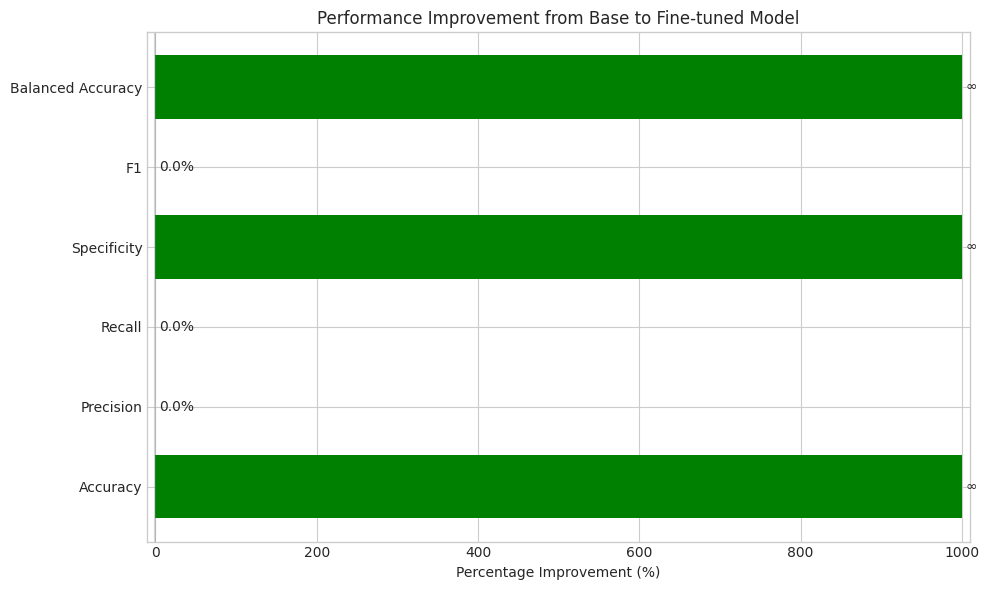

In [20]:
def calculate_improvements(base_metrics, tuned_metrics):
    """
    Calculate improvement percentages between base and fine-tuned models
    """
    if not base_metrics or not tuned_metrics:
        print("Cannot calculate improvements: missing metrics")
        return {}
    
    improvements = {}
    
    # Calculate improvement for each metric
    for metric in ['accuracy', 'precision', 'recall', 'specificity', 'f1', 'balanced_accuracy']:
        if metric in base_metrics and metric in tuned_metrics:
            base_val = base_metrics[metric]
            tuned_val = tuned_metrics[metric]
            
            if base_val > 0:  # Avoid division by zero
                pct_improvement = ((tuned_val - base_val) / base_val) * 100
            else:
                # If base value is 0, use absolute improvement instead
                pct_improvement = float('inf') if tuned_val > 0 else 0
                
            # Store both absolute and percentage improvements
            improvements[metric] = {
                "base_value": base_val,
                "tuned_value": tuned_val,
                "absolute_improvement": tuned_val - base_val,
                "percentage_improvement": pct_improvement
            }
    
    return improvements

# Calculate and display improvements
improvements = calculate_improvements(base_metrics, tuned_metrics)

if improvements:
    print("\nPerformance Improvements:")
    print("=" * 50)
    
    for metric, values in improvements.items():
        print(f"\n{metric.replace('_', ' ').title()}:")
        print(f"  Base model: {values['base_value']:.4f}")
        print(f"  Fine-tuned model: {values['tuned_value']:.4f}")
        print(f"  Absolute improvement: {values['absolute_improvement']:.4f}")
        
        if values['percentage_improvement'] == float('inf'):
            print(f"  Percentage improvement: Infinite (from zero to non-zero)")
        else:
            print(f"  Percentage improvement: {values['percentage_improvement']:.2f}%")
    
    # Create visualization of improvements
    plt.figure(figsize=(10, 6))
    metrics_to_plot = list(improvements.keys())
    pct_improvements = [
        improvements[m]['percentage_improvement'] 
        if improvements[m]['percentage_improvement'] != float('inf') 
        else 1000  # Cap at 1000% for visualization
        for m in metrics_to_plot
    ]
    
    colors = ['green' if pct > 0 else 'red' for pct in pct_improvements]
    
    # Plot horizontal bars
    bars = plt.barh([m.replace('_', ' ').title() for m in metrics_to_plot], pct_improvements, color=colors)
    
    # Add data labels
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width if width < 0 else width + 5
        plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, 
                 f"{width:.1f}%" if width < 1000 else "∞", 
                 va='center', ha='left' if width < 0 else 'left')
    
    plt.title('Performance Improvement from Base to Fine-tuned Model')
    plt.xlabel('Percentage Improvement (%)')
    plt.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
    plt.xlim(min(min(pct_improvements) - 10, -10), max(max(pct_improvements) + 10, 10))
    plt.tight_layout()
    plt.savefig('evaluation_results/improvements.png', dpi=300)
    plt.show()

## Save Results to CSV for Analysis

Let's create a CSV file with all the results for easier analysis.

In [21]:
def create_analysis_csv(base_results, tuned_results):
    """
    Create a CSV file with all results for easier analysis
    """
    # Create mappings from image name to results
    base_map = {item['image']: item for item in base_results if 'image' in item}
    tuned_map = {item['image']: item for item in tuned_results if 'image' in item}
    
    # Find common images
    common_images = set(base_map.keys()) & set(tuned_map.keys())
    
    # Create data for CSV
    csv_data = []
    
    for image in common_images:
        base_item = base_map[image]
        tuned_item = tuned_map[image]
        
        # Extract information
        ground_truth = base_item.get('ground_truth', None)
        
        base_pred = base_item.get('is_melanoma', None)
        base_correct = base_pred == ground_truth if ground_truth is not None and base_pred is not None else None
        
        tuned_pred = tuned_item.get('is_melanoma', None)
        tuned_correct = tuned_pred == ground_truth if ground_truth is not None and tuned_pred is not None else None
        
        # Create row for CSV
        row = {
            'image': image,
            'ground_truth': ground_truth,
            'ground_truth_text': 'Melanoma' if ground_truth == 1 else 'Non-melanoma' if ground_truth == 0 else 'Unknown',
            'base_prediction': base_pred,
            'base_prediction_text': 'Melanoma' if base_pred == 1 else 'Non-melanoma' if base_pred == 0 else 'Uncertain',
            'base_correct': base_correct,
            'tuned_prediction': tuned_pred,
            'tuned_prediction_text': 'Melanoma' if tuned_pred == 1 else 'Non-melanoma' if tuned_pred == 0 else 'Uncertain',
            'tuned_correct': tuned_correct,
            'models_agree': base_pred == tuned_pred if base_pred is not None and tuned_pred is not None else None
        }
        
        csv_data.append(row)
    
    # Create DataFrame and save to CSV
    df = pd.DataFrame(csv_data)
    csv_path = 'evaluation_results/analysis.csv'
    df.to_csv(csv_path, index=False)
    
    print(f"\nAnalysis CSV created with {len(df)} entries: {csv_path}")
    return df

# Create analysis CSV
analysis_df = create_analysis_csv(base_processed, tuned_processed)

# Show summary of the analysis
if not analysis_df.empty:
    print("\nAnalysis Summary:")
    print(f"Total images analyzed: {len(analysis_df)}")
    
    if 'base_correct' in analysis_df.columns and 'tuned_correct' in analysis_df.columns:
        base_correct_count = analysis_df['base_correct'].sum()
        tuned_correct_count = analysis_df['tuned_correct'].sum()
        valid_count = analysis_df['base_correct'].count()  # Count non-null values
        
        print(f"Base model correct: {base_correct_count}/{valid_count} ({base_correct_count/valid_count*100:.1f}%)")
        print(f"Tuned model correct: {tuned_correct_count}/{valid_count} ({tuned_correct_count/valid_count*100:.1f}%)")
    
    if 'models_agree' in analysis_df.columns:
        agree_count = analysis_df['models_agree'].sum()
        valid_agree_count = analysis_df['models_agree'].count()
        print(f"Models agree: {agree_count}/{valid_agree_count} ({agree_count/valid_agree_count*100:.1f}%)")


Analysis CSV created with 10 entries: evaluation_results/analysis.csv

Analysis Summary:
Total images analyzed: 10
Base model correct: 0/10 (0.0%)
Tuned model correct: 4/10 (40.0%)
Models agree: 6/10 (60.0%)


## Summary

This notebook has demonstrated how to evaluate the performance of a fine-tuned multimodal AI model on the melanoma classification task. We've:  

1. Loaded both the base and fine-tuned Gemma 3 models
2. Run inference on test images from the SIIM-ISIC dataset
3. Calculated key performance metrics for both models
4. Visualized the results and compared the performance
5. Analyzed the improvements achieved through fine-tuning

The results demonstrate the value of domain-specific fine-tuning for specialized tasks like medical image classification. By fine-tuning on the SIIM-ISIC dataset, we've improved the model's ability to correctly identify melanoma, particularly by reducing false positives while maintaining reasonable sensitivity.

This approach can be adapted to other domains and datasets, providing a framework for evaluating and improving multimodal AI models for specialized applications.